# Repeated parity measurement photon counting 

In [4]:
from pylab import*
import matplotlib.pyplot as plt
import seaborn as sns
from h5py import File
import pandas as pd
from slab.dsfit import*
import json
import numpy as np
from datetime import datetime
import scipy as sc
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
# from qutip import *
from h5py import File
import os
from slab.dataanalysis import get_next_filename

Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'
Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick


C:\ProgramData\Miniconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "
C:\ProgramData\Miniconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


# Fit functions

In [5]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(7):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y
def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/10.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, np.inf))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0], np.sqrt(pcov[0][0])

def expfunc2(x, p):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*np.exp**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, a, b, c):
    return b*np.exp(-(x-a)/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)


def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=p0)
    #     mu_g = popt[2]
    #     axs[2].plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=p0)
    #     mu_e = popt[5]
    #     axs[2].plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
    #     axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)

        axs[2].set_xlabel('I(a.u.)')        
        fig.show()
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)


def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

# HMM Model

In [6]:
class hmm_analysis:

    def __init__(self, qubit_params = None, cavity_params = None, readout_params = None):
        
        self.qubit_params = qubit_params
        self.cavity_params = cavity_params
        self.readout_params = readout_params

        """All the timescales are in μs"""
        self.qubit_t1 = qubit_params['t1']
        self.qubit_t2 = qubit_params['t2']
        self.qubit_nth = qubit_params['nth']
        
        self.cavity_t1 = cavity_params['t1']
        self.cavity_nth = cavity_params['nth']
        
        self.readout_len = readout_params['length']        
        self.trigger_period = readout_params['trigger']
        self.pi_length = readout_params['pi_pulse']

    ##----------------------------------------------------------------##
    def forward(self, meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

    def backward(self, meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta

    def likelihood(self, meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  self.forward(meas_seq, T, E)[-1].sum()

    def gamma(self, meas_seq, T, E):
        alpha = self.forward(meas_seq, T, E)
        beta  = self.backward(meas_seq, T, E)
        obs_prob = self.likelihood(meas_seq, T, E)
        return (multiply(alpha, beta.T) / obs_prob)

    def viterbi(self, meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    ##----------------------------------------------------------------##
    def alpha_awg_cal(self, cav_amp=0.4, cav_len=250):
        # takes input array of amps and length and converts them to output array of alphas,
        # using a calibration h5 file defined in the experiment config
        # pull calibration data from file, handling properly in case of multimode cavity
        cal_path = 'C:\_Lib\python\slab\experiments\qm_opx\drive_calibration'

        fn_file = cal_path + '\\00000_2021_7_30_cavity_square.h5'

        with File(fn_file, 'r') as f:
            omegas = np.array(f['omegas'])
            amps = np.array(f['amps'])

        # assume zero frequency at zero amplitude, used for interpolation function
        omegas = np.append(omegas, 0.0)
        amps = np.append(amps, 0.0)

        o_s = omegas
        a_s = amps

        # interpolate data, transfer_fn is a function that for each amp returns the corresponding omega
        transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

        omega_desired = transfer_fn(cav_amp)
        alpha = omega_desired * cav_len

        """Returns alpha in the cavity"""
        return alpha
        
    ##----------------------------------------------------------------##
    def openfile(self, filename):
        
        return File(filename,'r')

    def stateprep(self, data_filename, at_end=True, t2_err = 0.0):
        
        """Readout fidelities from an independent measurement"""
        g_infidelity, e_infidelity = 0.0198, 0.0694
        
        self.a = self.openfile(data_filename)

        bit1 = np.array(self.a['bit1'])[:]
        bit2 = np.array(self.a['bit2'])[:]
        bit3 = pd.DataFrame(self.a['bit3'])[:]
        
        p_cav = np.array(self.a['p_cav'])/100
        cav_amp = np.array(self.a['amp'])
        cav_len = np.array(self.a['time'])
        npi_m = int(np.array(self.a['pi_m']))
        npi_n = int(np.array(self.a['pi_n']))

        self.a.close()
        
        df = bit3
        alpha = self.alpha_awg_cal(cav_amp, cav_len)
        print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
        print('Coherent drive: amp = {}, length = {} ns'.format(cav_amp, cav_len))

        nx, ny = np.shape(df)
                
        """Renaming the columns of repeated pi pulses"""
        l = []
        for i in range(ny):
            l.append('π%i'%i)
        df.columns = l

        df['n'] = 2*bit2 + bit1

        cols = df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df = df[cols].sort_values(by=['n'])

        """Find out the unique Fock levels and their occurences"""

        (unique, counts) = np.unique(df['n'], return_counts=True)

        print(unique, counts)
        
        p_m_counts = []
        p_n_counts = []
        
        index = 0
        for ii in range(len(unique)):
            pm_temp = []
            pn_temp = []
            
            fstate_in = unique[ii]+1

            cavity_t1 = self.cavity_t1/fstate_in
            Pnm =  (1-np.exp(-self.trigger_period/cavity_t1)) + self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))

            Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
            Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) +\
                (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)
            Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)

            T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
                 [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
                 [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
                 [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

            E = 0.5*asarray([[1-g_infidelity, g_infidelity],
                [e_infidelity, 1- e_infidelity],
                [1-g_infidelity, g_infidelity],
                [e_infidelity, 1- e_infidelity]])
            
            for jj in range(counts[ii]):
                """State preparation probabilities at the end or at the beginning of m π pulses"""
                meas_seq = df.iloc[index + jj][1:1+npi_m]
                gamma_matrix = self.gamma(meas_seq, T, E)
                if at_end==True: #Probablitity of state surviving till the end
                    P0_last = gamma_matrix[-1,0] + gamma_matrix[-1,1]
                    P1_last = gamma_matrix[-1,2] + gamma_matrix[-1,3]
                else:#Probability at the beginnning
                    P0_last = gamma_matrix[0,0] + gamma_matrix[0,1]
                    P1_last = gamma_matrix[0,2] + gamma_matrix[0,3]   
                pm_temp.append(P1_last/P0_last)

                """After the coherent drive, probabilities at the begining of n π pulses"""    
                meas_seq = df.iloc[index + jj][npi_m:]
                gamma_matrix = self.gamma(meas_seq, T, E)
                P0_first = gamma_matrix[0,0] + gamma_matrix[0,1]
                P1_first = gamma_matrix[0,2] + gamma_matrix[0,3]   
                pn_temp.append(P1_first/P0_first)

            index = index + counts[ii]
            p_m_counts.append(pm_temp)
            p_n_counts.append(pn_temp)

        return alpha, unique, counts, p_m_counts, p_n_counts

In [7]:
class hmm_analysis_2:

    def __init__(self, qubit_params = None, cavity_params = None, readout_params = None):
        
        self.qubit_params = qubit_params
        self.cavity_params = cavity_params
        self.readout_params = readout_params

        """All the timescales are in μs"""
        self.qubit_t1 = qubit_params['t1']
        self.qubit_t2 = qubit_params['t2']
        self.qubit_nth = qubit_params['nth']
        
        self.cavity_t1 = cavity_params['t1']
        self.cavity_nth = cavity_params['nth']
        
        self.readout_len = readout_params['length']        
        self.trigger_period = readout_params['trigger']
        self.pi_length = readout_params['pi_pulse']
        self.g_inf = readout_params['g_inf']        
        self.e_inf = readout_params['e_inf']        

    ##----------------------------------------------------------------##
    def forward(self, meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

    def backward(self, meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta

    def likelihood(self, meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  self.forward(meas_seq, T, E)[-1].sum()

    def gamma(self, meas_seq, T, E):
        alpha = self.forward(meas_seq, T, E)
        beta  = self.backward(meas_seq, T, E)
        obs_prob = self.likelihood(meas_seq, T, E)
        return (multiply(alpha, beta.T) / obs_prob)

    def viterbi(self, meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    ##----------------------------------------------------------------##
    def alpha_awg_cal(self, cav_amp=0.4, cav_len=250):
        # takes input array of amps and length and converts them to output array of alphas,
        # using a calibration h5 file defined in the experiment config
        # pull calibration data from file, handling properly in case of multimode cavity
        cal_path = 'C:\_Lib\python\slab\experiments\qm_opx\drive_calibration'

        fn_file = cal_path + '\\00000_2021_7_30_cavity_square.h5'

        with File(fn_file, 'r') as f:
            omegas = np.array(f['omegas'])
            amps = np.array(f['amps'])

        # assume zero frequency at zero amplitude, used for interpolation function
        omegas = np.append(omegas, 0.0)
        amps = np.append(amps, 0.0)

        o_s = omegas
        a_s = amps

        # interpolate data, transfer_fn is a function that for each amp returns the corresponding omega
        transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

        omega_desired = transfer_fn(cav_amp)
        alpha = omega_desired * cav_len

        """Returns alpha in the cavity"""
        return alpha
        
    ##----------------------------------------------------------------##
    def openfile(self, filename):

        return File(filename,'r')

    def stateprep(self, fstate_in=0, data_filename=None, at_end=True, t2_err=0.0):
        
        """Readout fidelities from an independent measurement"""
        g_infidelity, e_infidelity = self.g_inf, self.e_inf
        
        self.a = self.openfile(data_filename)

        bit3 = pd.DataFrame(self.a['bit3'])[:]
        
        cav_amp = np.array(self.a['amp'])
        cav_len = np.array(self.a['time'])
        npi_m = int(np.array(self.a['pi_m']))
        npi_n = int(np.array(self.a['pi_n']))

        self.a.close()
        
        df = bit3
        alpha = self.alpha_awg_cal(cav_amp, cav_len)
        print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
        print('Coherent drive: amp = {}, length = {} ns'.format(cav_amp, cav_len))

        nx, ny = np.shape(df)
                
        """Renaming the columns of repeated pi pulses"""
        l = []
        for i in range(ny):
            l.append('π%i'%i)
        df.columns = l

        """Find out the unique Fock levels and their occurences"""
        
        p_m_counts = []
        
        """T and E matrices for the state prep part"""
        fstate_in = 0

        if fstate_in ==0:
            cavity_t1 = self.cavity_t1/(fstate_in+1)
            Pnm =  self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))
        else: 
            cavity_t1 = self.cavity_t1/(fstate_in)
            Pnm =  (1-np.exp(-self.trigger_period/cavity_t1)) + self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))

        Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\

        Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) +\
            (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)
        Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
            (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)

        T = np.asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
             [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
             [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
             [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

        E = 0.5*np.asarray([[1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity],
            [1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity]])
            
        for jj in range(len(df)):
            """State preparation probabilities at the end or at the beginning of m π pulses"""
            meas_seq = df.iloc[jj]
            gamma_matrix = self.gamma(meas_seq, T, E)
            if at_end==True: #Probablitity of state surviving till the end
                P0_last = gamma_matrix[-1,0] + gamma_matrix[-1,1]
                P1_last = gamma_matrix[-1,2] + gamma_matrix[-1,3]
            else:#Probability at the beginnning
                P0_last = gamma_matrix[0,0] + gamma_matrix[0,1]
                P1_last = gamma_matrix[0,2] + gamma_matrix[0,3]   
            p_m_counts.append(P1_last/P0_last)

        return alpha, cav_amp, p_m_counts

# Varying injected alpha

## 0.0

In [29]:
qubit_params = {'t1':120, 't2':130, 'nth':1e-2}
cavity_params = {'t1':6.0e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':4.768, 'pi_pulse':565e-3, 'g_inf':0.0246, 'e_inf':0.0408}
expt_name = 'photon_counting_parity_alpha'

filelist = np.arange(183, 184, 1)

p_m_counts = []
alphas = []
camp = []
for ii, i in enumerate(filelist):
    p_m_temp = []
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    print(filename)
    obj = hmm_analysis_2(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, c_amp, p_m_temp = obj.stateprep(data_filename=filename, at_end=False)
    alphas.append(alpha)
    camp.append(c_amp)
    p_m_counts.append(p_m_temp)

..\data\00183_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.0, length = 400 ns


In [30]:
alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=400*np.ones(len(camp)))
path = "../data/photon_counting/g0_20210731/"
for i in range(len(filelist)):

    filename = path + "n" + str(0) +"_camp_" + str(camp[i])+"_len_"+str(400)+".h5"
    print(filename)
    
    temp= p_m_counts[i]
    
    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=temp)
        f.create_dataset('alpha', data = alphas[i])

../data/photon_counting/g0_20210731/n0_camp_0.0_len_400.h5


## 0.0005-0.0009

In [91]:
qubit_params = {'t1':120, 't2':130, 'nth':2.2e-2}
cavity_params = {'t1':6.0e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':4.768, 'pi_pulse':565e-3, 'g_inf':0.0246, 'e_inf':0.0408}
expt_name = 'photon_counting_parity_alpha'

filelist = np.arange(178, 183, 1)

p_m_counts = []
alphas = []
camp = []
for ii, i in enumerate(filelist):
    p_m_temp = []
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    print(filename)
    obj = hmm_analysis_2(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, c_amp, p_m_temp = obj.stateprep(data_filename=filename, at_end=False)
    alphas.append(alpha)
    camp.append(c_amp)
    p_m_counts.append(p_m_temp)

..\data\00178_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.0005, length = 400 ns
..\data\00179_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.0006, length = 400 ns
..\data\00180_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.0007, length = 400 ns
..\data\00181_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.0008, length = 400 ns
..\data\00182_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.0009, length = 400 ns


In [ ]:
lambd_th = 1e7
pos_events = []
pos_events_err = []

for i in range(len(filelist)):
    df = pd.DataFrame(p_m_counts[i])
    t = df[df>lambd_th].count()/len(p_m_counts[i])
    pos_events.append(t)
    pos_events_err.append(np.sqrt(df[df>lambd_th].count())/len(p_m_counts[i]))
pos_events = np.array(pos_events).flatten()
pos_events_err = np.array(pos_events_err[:]).flatten()

In [92]:
alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=400*np.ones(len(camp)))
path = "../data/photon_counting/g0_20210731/"
for i in range(len(filelist)):

    filename = path + "n" + str(0) +"_camp_" + str(camp[i])+"_len_"+str(400)+".h5"
    print(filename)
    
    temp= p_m_counts[i]
    
    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=temp)
        f.create_dataset('alpha', data = alphas[i])

../data/photon_counting/g0_20210731/n0_camp_0.0005_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.0006_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.0007_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.0008_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.0009_len_400.h5


## 0.001-0.009 

In [93]:
qubit_params = {'t1':120, 't2':130, 'nth':2.2e-2}
cavity_params = {'t1':6.0e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':4.768, 'pi_pulse':565e-3, 'g_inf':0.0246, 'e_inf':0.0408}
expt_name = 'photon_counting_parity_alpha'

filelist = np.arange(169, 178, 1)

p_m_counts = []
alphas = []
camp = []
for ii, i in enumerate(filelist):
    p_m_temp = []
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    print(filename)
    obj = hmm_analysis_2(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, c_amp, p_m_temp = obj.stateprep(data_filename=filename, at_end=False)
    alphas.append(alpha)
    camp.append(c_amp)
    p_m_counts.append(p_m_temp)

..\data\00169_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.001, length = 400 ns
..\data\00170_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.002, length = 400 ns
..\data\00171_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.003, length = 400 ns
..\data\00172_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.004, length = 400 ns
..\data\00173_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.005, length = 400 ns
..\data\00174_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.006, length = 400 ns
..\data\00175_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.007, length = 400 ns
..\data\00176_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.008, length = 400 ns
..\data\00177_photon_counting_parity_alpha.h5
# of π at m= 30, a

In [26]:
lambd_th = 1e7
pos_events = []
pos_events_err = []

for i in range(len(filelist)):
    df = pd.DataFrame(p_m_counts[i])
    t = df[df>lambd_th].count()/len(p_m_counts[i])
    pos_events.append(t)
    pos_events_err.append(np.sqrt(df[df>lambd_th].count())/len(p_m_counts[i]))
pos_events = np.array(pos_events).flatten()
pos_events_err = np.array(pos_events_err[:]).flatten()

In [94]:
alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=400*np.ones(len(camp)))
path = "../data/photon_counting/g0_20210731/"
for i in range(len(filelist)):

    filename = path + "n" + str(0) +"_camp_" + str(camp[i])+"_len_"+str(400)+".h5"
    print(filename)
    
    temp= p_m_counts[i]
    
    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=temp)
        f.create_dataset('alpha', data = alphas[i])

../data/photon_counting/g0_20210731/n0_camp_0.001_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.002_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.003_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.004_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.005_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.006_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.007_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.008_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.009_len_400.h5


## 0.01-0.09

In [95]:
qubit_params = {'t1':120, 't2':130, 'nth':2.2e-2}
cavity_params = {'t1':6.0e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':4.768, 'pi_pulse':565e-3, 'g_inf':0.0246, 'e_inf':0.0408}
expt_name = 'photon_counting_parity_alpha'

filelist = np.arange(160, 169, 1)

p_m_counts = []
alphas = []
camp = []
for ii, i in enumerate(filelist):
    p_m_temp = []
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    print(filename)
    obj = hmm_analysis_2(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, c_amp, p_m_temp = obj.stateprep(data_filename=filename, at_end=False)
    alphas.append(alpha)
    camp.append(c_amp)
    p_m_counts.append(p_m_temp)

..\data\00160_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.01, length = 400 ns
..\data\00161_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.02, length = 400 ns
..\data\00162_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.03, length = 400 ns
..\data\00163_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.04, length = 400 ns
..\data\00164_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.05, length = 400 ns
..\data\00165_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.06, length = 400 ns
..\data\00166_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.07, length = 400 ns
..\data\00167_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.08, length = 400 ns
..\data\00168_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0


In [32]:
lambd_th = 1e7
pos_events = []
pos_events_err = []

for i in range(len(filelist)):
    df = pd.DataFrame(p_m_counts[i])
    t = df[df>lambd_th].count()/len(p_m_counts[i])
    pos_events.append(t)
    pos_events_err.append(np.sqrt(df[df>lambd_th].count())/len(p_m_counts[i]))
pos_events = np.array(pos_events).flatten()
pos_events_err = np.array(pos_events_err[:]).flatten()

In [96]:
alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=400*np.ones(len(camp)))
path = "../data/photon_counting/g0_20210731/"
for i in range(len(filelist)):

    filename = path + "n" + str(0) +"_camp_" + str(camp[i])+"_len_"+str(400)+".h5"
    print(filename)
    
    temp= p_m_counts[i]
    
    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=temp)
        f.create_dataset('alpha', data = alphas[i])

../data/photon_counting/g0_20210731/n0_camp_0.01_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.02_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.03_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.04_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.05_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.06_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.07_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.08_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.09_len_400.h5


## 0.1-0.9

In [19]:
qubit_params = {'t1':122, 't2':130, 'nth':1e-2}
cavity_params = {'t1':6.0e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':4.768, 'pi_pulse':565e-3, 'g_inf':0.0246, 'e_inf':0.0408}
expt_name = 'photon_counting_parity_alpha'

filelist = np.arange(151, 159, 1)

filelist = [151]

p_m_counts = []
alphas = []
camp = []
for ii, i in enumerate(filelist):
    p_m_temp = []
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    print(filename)
    obj = hmm_analysis_2(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, c_amp, p_m_temp = obj.stateprep(data_filename=filename, at_end=False, t2_err=0.0)
    alphas.append(alpha)
    camp.append(c_amp)
    p_m_counts.append(p_m_temp)

..\data\00151_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.1, length = 400 ns


In [20]:
np.shape(p_m_counts[0])

(10000,)

In [22]:
df = pd.DataFrame(p_m_counts[0])
th = 1e9
print(df[df>th].count())

0    127
dtype: int64


In [11]:
camp = np.round(np.arange(0.1, 0.9, 0.1).tolist(), 4)

alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=400*np.ones(len(camp)))

In [98]:
alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=400*np.ones(len(camp)))
path = "../data/photon_counting/g0_20210731/"
for i in range(len(filelist)):

    filename = path + "n" + str(0) +"_camp_" + str(camp[i])+"_len_"+str(400)+".h5"
    print(filename)
    
    temp= p_m_counts[i]
    
    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=temp)
        f.create_dataset('alpha', data = alphas[i])

../data/photon_counting/g0_20210731/n0_camp_0.1_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.2_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.3_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.4_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.5_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.6_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.7_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.8_len_400.h5


In [8]:
np.shape(p_m_counts)

(8, 25000)

In [ ]:
pos_events_err

In [43]:
qubit_params = {'t1':100, 't2':130, 'nth':5e-2}
cavity_params = {'t1':6.0e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':7.2, 'pi_pulse':500e-3, 'g_inf':0.0246, 'e_inf':0.0408}
expt_name = 'photon_counting_parity_alpha'

filelist = np.arange(133, 141, 1)

p_m_counts = []
alphas = []
camp = []
for ii, i in enumerate(filelist):
    p_m_temp = []
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    print(filename)
    obj = hmm_analysis_2(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, c_amp, p_m_temp = obj.stateprep(data_filename=filename, at_end=False)
    alphas.append(alpha)
    camp.append(c_amp)
    p_m_counts.append(p_m_temp)

..\data\00133_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.1, length = 400 ns
..\data\00134_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.2, length = 400 ns
..\data\00135_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.3, length = 400 ns
..\data\00136_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.4, length = 400 ns
..\data\00137_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.5, length = 400 ns
..\data\00138_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.6, length = 400 ns
..\data\00139_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.7, length = 400 ns
..\data\00140_photon_counting_parity_alpha.h5
# of π at m= 30, at n = 0
Coherent drive: amp = 0.8, length = 400 ns


In [44]:
lambd_th = 1e7
pos_events = []
pos_events_err = []

for i in range(len(filelist)):
    df = pd.DataFrame(p_m_counts[i])
    t = df[df>lambd_th].count()/len(p_m_counts[i])
    pos_events.append(t)
    pos_events_err.append(np.sqrt(df[df>lambd_th].count())/len(p_m_counts[i]))
pos_events = np.array(pos_events).flatten()
pos_events_err = np.array(pos_events_err[:]).flatten()

In [45]:
pos_events

array([0.0157, 0.0623, 0.1225, 0.1935, 0.245 , 0.293 , 0.3245, 0.3268])

In [47]:
th = 1e9
df[df>th].count()

0    3053
dtype: int64

In [48]:
alphas = obj.alpha_awg_cal(cav_amp=camp, cav_len=400*np.ones(len(camp)))
path = "../data/photon_counting/g0_20210731/"
for i in range(len(filelist)):

    filename = path + "n" + str(0) +"_camp_" + str(camp[i])+"_len_"+str(400)+".h5"
    print(filename)
    
    temp= p_m_counts[i]
    
    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=temp)
        f.create_dataset('alpha', data = alphas[i])

../data/photon_counting/g0_20210731/n0_camp_0.1_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.2_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.3_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.4_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.5_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.6_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.7_len_400.h5
../data/photon_counting/g0_20210731/n0_camp_0.8_len_400.h5


# Test

In [23]:
filename = "../data/photon_counting/g0_20210731/test/n0_camp_0.1_len_400.h5"
with File(filename,'r') as a:
    p_m_counts = np.array(a['p_m_counts'], dtype=float)
    alpha = np.array(a['alpha'])

In [28]:
for i in range(len(p_m_counts)):
    df = pd.DataFrame(p_m_counts[i])
    th = 1e9
    print(df[df>th].count())

0    127
dtype: int64
0    66
dtype: int64
0    0
dtype: int64
0    0
dtype: int64


# photon counter fit

In [32]:
data_path =  "../data/photon_counting/g0_20210731/"
filenames_like = os.listdir(data_path)

th_m = np.logspace(2, 10, 9)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_m:
        df = pd.DataFrame(p_m_counts)
        count_m = df[df>th].count()
        t = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_m)/len(p_m_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_m_counts), count_m))
    detected_th[np.round(alpha, 6)]= detect
    detected_th_err[np.round(alpha, 6)] = detect_err

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n0_camp_0.0005_len_400.h5
0.000592
Total number of events collected: 100000, 18 events crossed \lambda 
n0_camp_0.0006_len_400.h5
0.00071
Total number of events collected: 100000, 12 events crossed \lambda 
n0_camp_0.0007_len_400.h5
0.000829
Total number of events collected: 100000, 30 events crossed \lambda 
n0_camp_0.0008_len_400.h5
0.000947
Total number of events collected: 100000, 20 events crossed \lambda 
n0_camp_0.0009_len_400.h5
0.001066
Total number of events collected: 100000, 20 events crossed \lambda 
n0_camp_0.001_len_400.h5
0.001184
Total number of events collected: 50000, 9 events crossed \lambda 
n0_camp_0.002_len_400.h5
0.002809
Total number of events collected: 50000, 9 events crossed \lambda 
n0_camp_0.003_len_400.h5
0.0044
Total number of events collected: 50000, 9 events crossed \lambda 
n0_camp_0.004_len_400.h5
0.005909
Total number of events collected: 50000, 16 events crossed \lambda 
n0_camp_0.005_len_400.h5
0.007447
Total number of events collected: 50000, 11 

In [33]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_m)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])

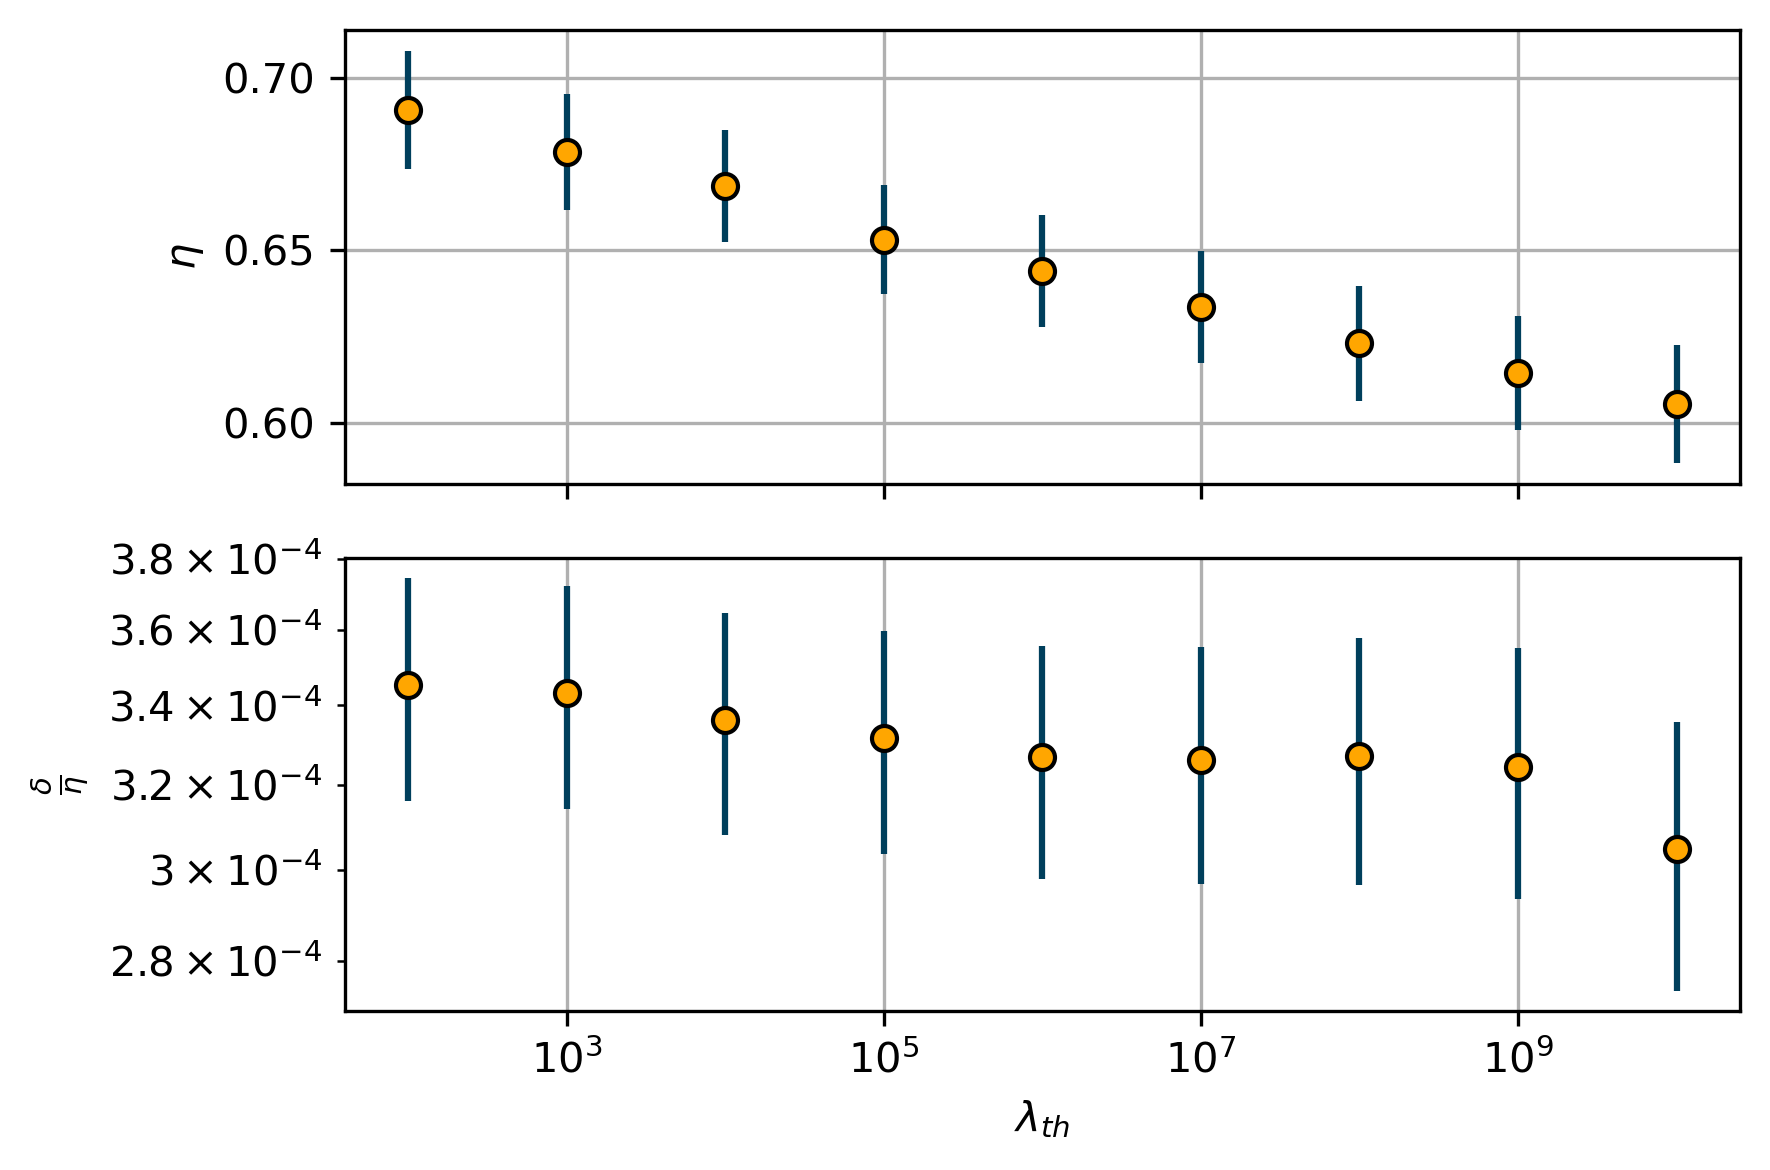

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_m, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_m, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.03594


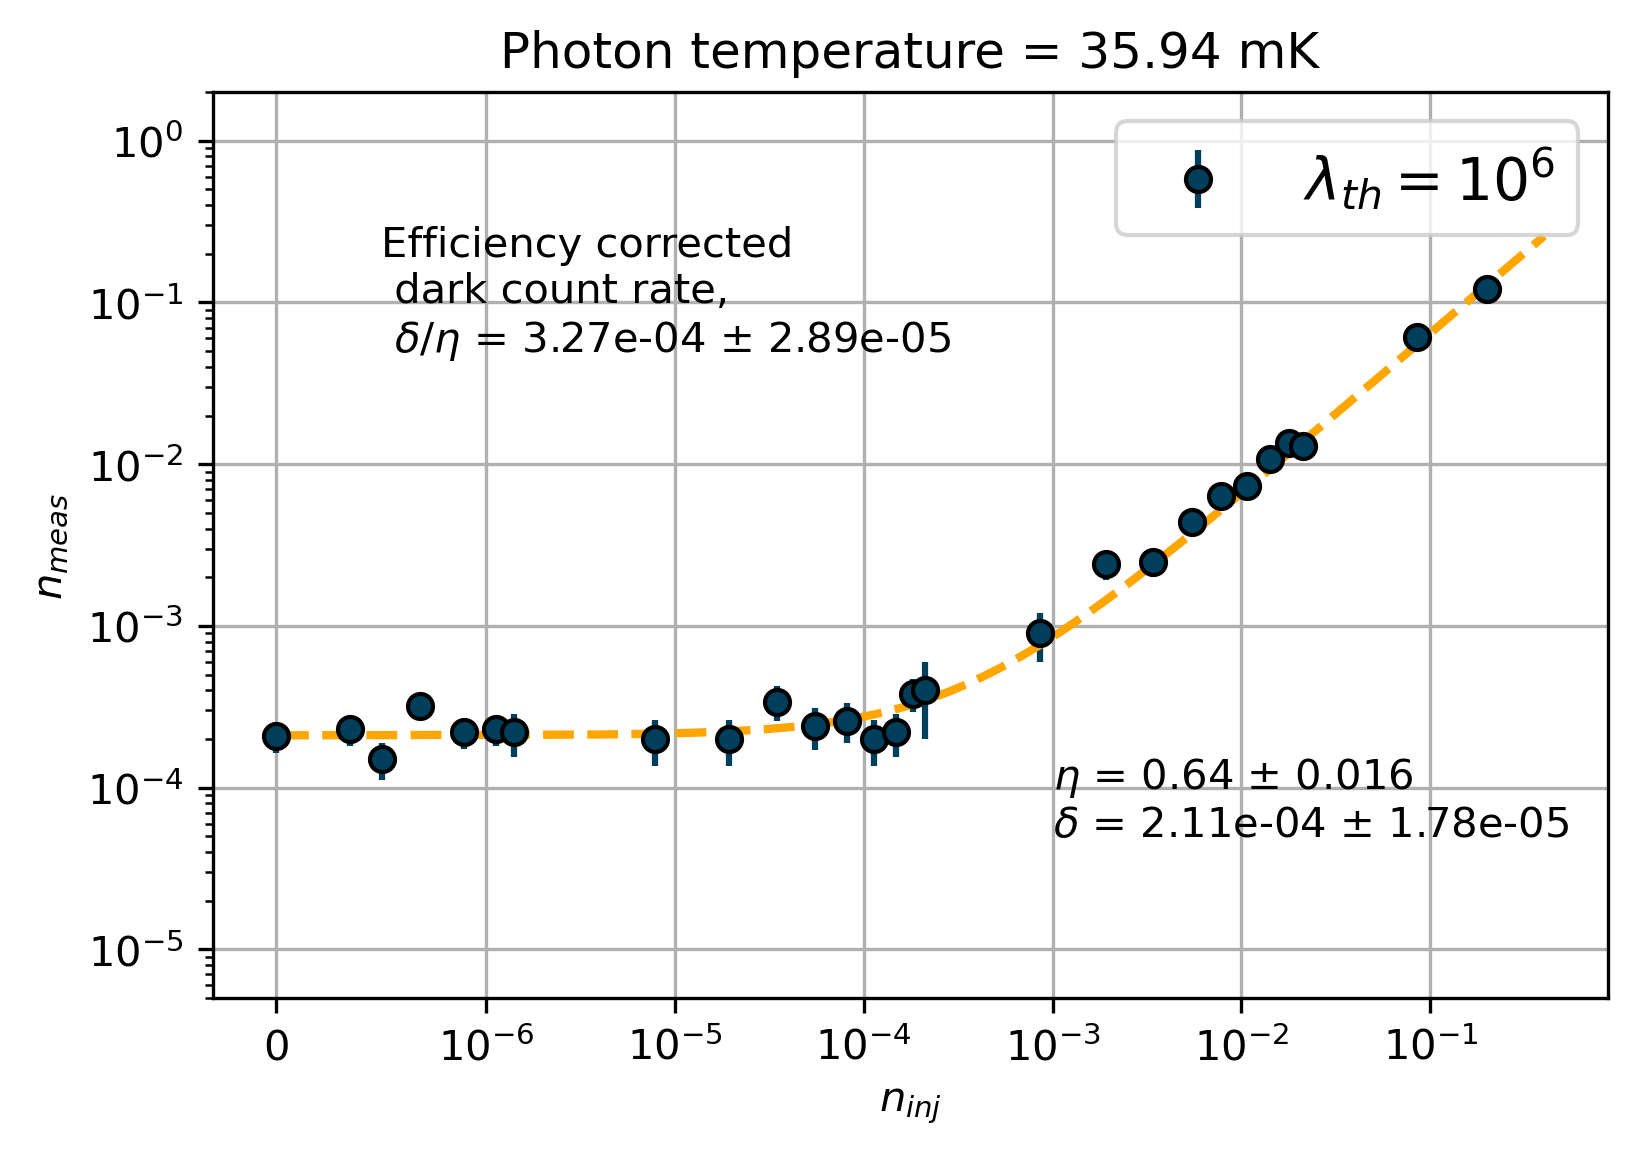

In [35]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 5
plt.figure(dpi=300)
plt.errorbar(n_exp, y= y.iloc[-m], yerr= yerr.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_m[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[-m], dtype=float), sigma=np.array(yerr.iloc[-m], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(5e-6, 2e0)
plt.text(1e-3, 5e-5, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-08-01-PhotonCounting.png', dpi=300)
plt.show()

In [73]:
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = hbar*w/(k*np.log(1/3.28e-4))
print(T)

0.03595919112878462
